# Lafayette Motorsports Lap Time Simulator 
By: Matt Post '22 ||
Lafayette College, Dept. Mechanical Engineering ||
AY: 2021-2022

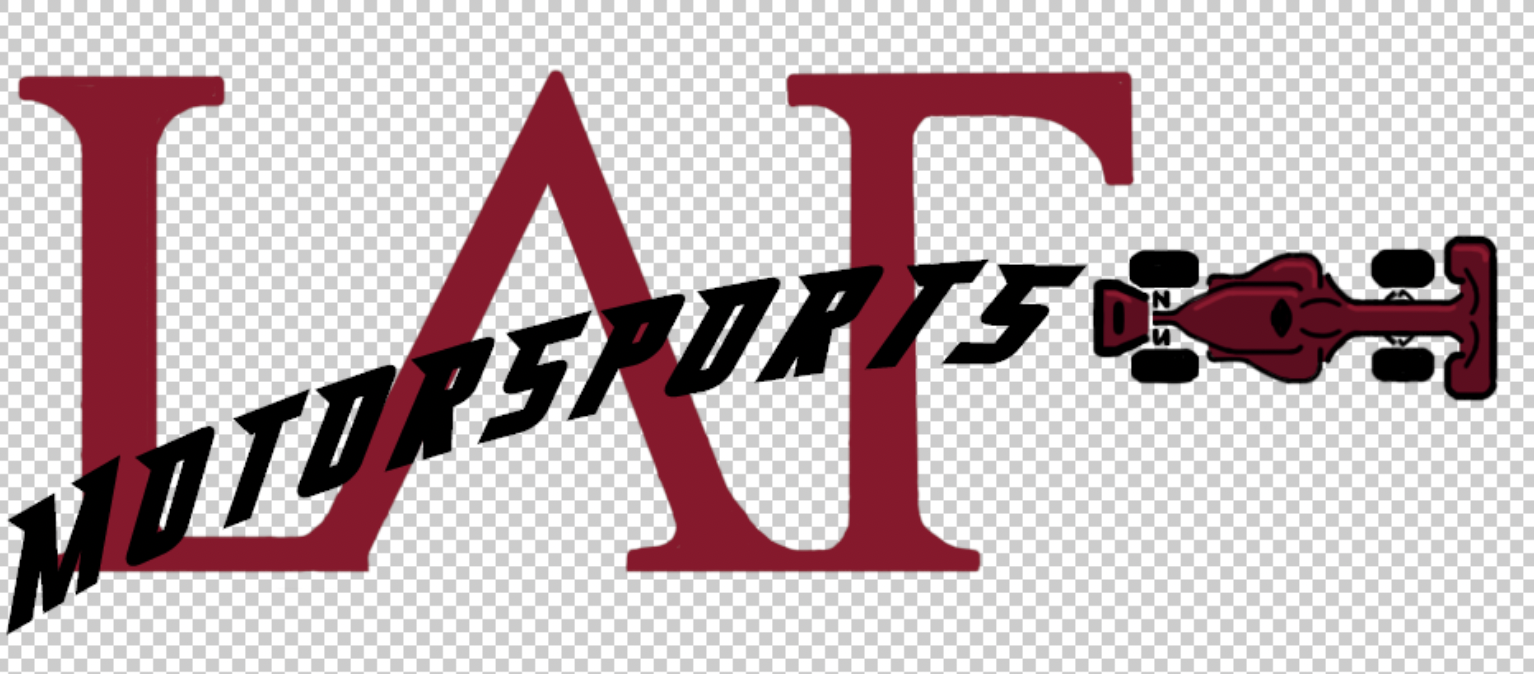

This notebook details the laptime simulator being developed for the Lafayette Motorsports joint venture between the ME 497/498: Senior Design Team & the preformance based club. The development of this simulation has been lead by M. Post '22 & Prof. A. Brown. The following members of the Senior Design team have contributed to this code base: H.Ma '22 (Drivetrain simulation), G. Hartman '22 (Steering simulation).

# Motivation

This simulation has been constructed in order to investigate how changing design parameters will impact preformance of the formula hybrid vehicle. This simulation has been build off of theory provided by Prof. Alexander Brown provided in his 2017 course-- ME 477: The Need For Speed. This simulation asusmes a point mass racer that will make "perfect" decisions while driving. While this simulation is less complex that a commercial alternative, the long term goal is to conteraze the system in order to make it open acess and usable by other Formula competition teams.  

## Construct Track

This cell loads in in GPS data of the endurance track and converts it to mathmatical representations of the track. This endevor does not currntely have access to GPS data for the endurance track for the formula hybrid NH endurance track. As such, using J.image to create X & Y data which can be converted to Station, Curviture, and heading data.  

In [53]:
clear all;

data = load("XY_data3.txt");
X = data(:,1);
%X = X*-1
Y = data(:,2);
%Z = data(:,3); % elevation from topographic map (m)

X(length(X+1))=X(1); %returning to the finish line
Y(length(Y+1))=Y(1);
%Z(length(Z+1))=Z(1);


AngleOfRotation = 108; % degrees, angle to rotate to get North pointing verticle
xEast = X*cosd(AngleOfRotation)+Y*sind(AngleOfRotation);
yNorth = -X*sind(AngleOfRotation)+Y*cosd(AngleOfRotation);
scale = 54/100; %meters/pixel
S(1)=0;
for i=2:length(X)
    dS = sqrt((xEast(i)-xEast(i-1))^2+(yNorth(i)-yNorth(i-1))^2);
    S(i)=dS+S(i-1);
    v(i) = atan2d((yNorth(i)-yNorth(i-1)),(xEast(i)-xEast(i-1))); % track heading
end
S=S(1:length(S))*scale; # Convert to useful units. (multiply the scale by pixels to get Station in meters)
degree_to_rad_CF = 0.0174533; # Conversion factor of degrees to radians
K = [0 diff(v)./diff(S)]*degree_to_rad_CF; % Track curviture, rad/m 
K = medfilt1(K,5);
N = length(S)-12;
K = K(1:N);
v = v(1:N);
S=S(1:N);
S(end)

ans =  989.74


## Plotting Stuff

Plot relevant data: ENU Track, Heading vs Station, Curviture vs Station.

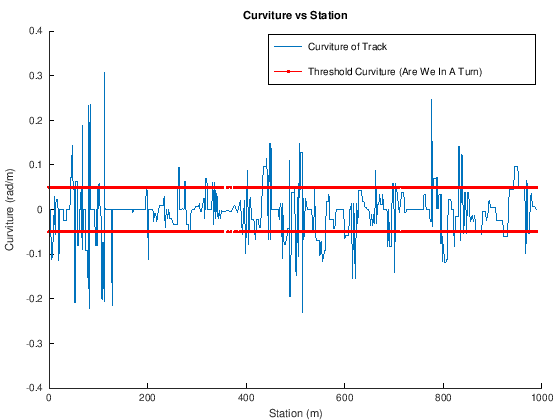

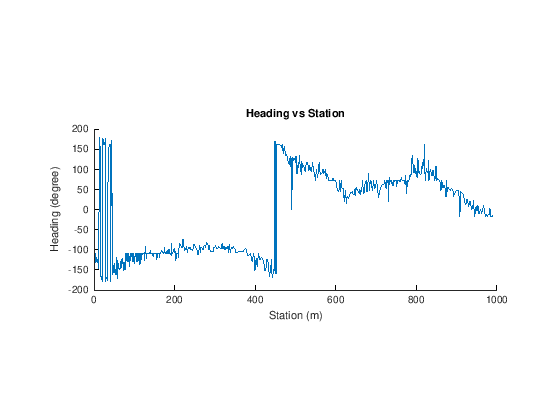

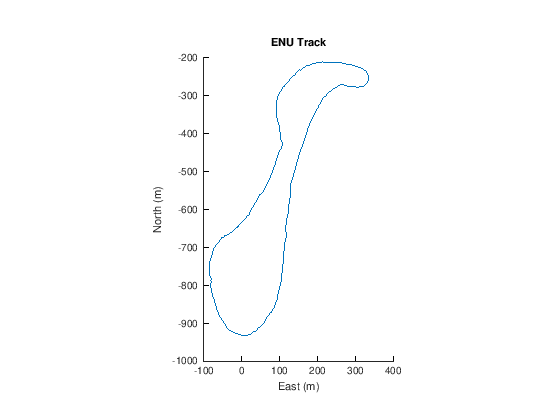

In [2]:
%Plot Track -- ENU, Curviture, Heading...ETC
figure(1)
hold on
title("ENU Track")
xlabel("East (m)")
ylabel("North (m)")
plot(xEast,yNorth)
daspect([1 1 1])
hold off

figure(2)
hold on
title("Heading vs Station")
xlabel("Station (m)")
ylabel("Heading (degree)")
plot(S,v)
daspect([1 1 1])
hold off

figure(3)
hold on 

title("Curviture vs Station")
xlabel("Station (m)")
ylabel("Curviture (rad/m)")
plot(S,K)
plot(S,0.05,"r")
plot(S,-0.05,"r")
legend("Curviture of Track","Threshold Curviture (Are We In A Turn)")
%daspect([1 1 1])
hold off

# Create Functions To Streamline Simulation

#### BLOCK DIAGRAM OF SYSTEM HERE
The block diagram above shows the functions that will be fed into the overall lap time simulator.

### Define Relevant Constants:

In [3]:
g = 9.81; %m/s^2
a_turn_max = 1.3*g;
a_brake_max = 1.0*g;

### Finding K_Here for a given instance

This function will detemine the curviture of specifcic station point using the interp1 function. By building another function off of interp1 it will make it easier to know what is being called each time.

In [4]:
function K_here = K_hereFunc(S_track,K_track,S_here)
    K_here = interp1(S_track,K_track,S_here);
end

### Unit Test For K_here

Test K_here by feeding in some random indexed value of S. If it works then we should have the corresponding value curviture.

In [5]:
S_here = S(20)
K_here = K_hereFunc(S,K,S_here) # reported curviture for input station value

S_here =  33.586
K_here = -0.024281


### Are We In A Turn Function:

Assigns a boolean depending on if we are in a turn. Boolean will allow us to assign car acceleration in future function. This is the first logic function to make our "smart driver" our model assumes that the driver is perfect and will make the "perfect" decision at each point.

In [6]:
function bool_turn = AreWeInATurn(K_here)
    K_thresh = 1/200; %radians
    if abs(K_here)>K_thresh
        bool_turn = true;
    else bool_turn = false;
    end
end

### Unit Test for Are We In A Turn

In [7]:
bool_turn_test_1 = AreWeInATurn(0) # 0 Is less than K_thresh so we should get false (0)
bool_turn_test_2 = AreWeInATurn(.21) # 100 Is greater than K_thresh so we should get true (1)

bool_turn_test_1 = 0
bool_turn_test_2 = 1


### S_dot_crit Function:

This function will return the critical speed of the car for us to determine if we're going too fast

In [8]:
function S_dot_crit = CritSpeed(K_next,fy_max)
    g = 9.81; % m/s^2, gravitational acceleration
    S_dot_crit = sqrt((fy_max*g)/abs(K_next));
end

### Unit Test S_dot_crit function:

In [9]:
S_dot_crit = CritSpeed(.10,100)

S_dot_crit =  99.045


### K_next Function:

This function returns the curviture of the next turn & the distance to the next turn. This is achomplished by a logical statement that relies on the Station track being greater than S_here and the values of K being greater than 1 / min_turn_radius of the car.

In [10]:
function [K_next,dist_to_next_turn] = NextCurviture(S,K,S_here)
    indicies = 1:length(S);
    min_turn_radius = 6; # minimum turning radius, Verfied by calculations done by G. Hartman
    turn_ahead_indicies = indicies(S>S_here & abs(K) > 1/min_turn_radius); # find indicies until the next turn
    if length(turn_ahead_indicies)>1
        next_turn_index = turn_ahead_indicies(1); # reports index of next turn
        K_next = K(next_turn_index); % reports the curviture of next turn [should be greater than abs(0.05)]
        %next_turn_indicies =  
    else 
        next_turn_index = indicies(end);
        K_next = K(end);
    end
    dist_to_next_turn = S(next_turn_index)-S_here;
end

### K_next Unit Test

In [11]:
S_test = 0; %m, input S_here
[K_test,dist_test] = NextCurviture(S,K,S_test)

K_test = -0.20832
dist_test =  51.803


### S_crit_brake Function:

This function will determine the critical braking speed of the car given the distance to the next turn and the max longitudinal acceleration

In [12]:
function S_dot_crit_brake = CritBrake(S_crit_turn,ay_max,dist_to_next_turn)
    S_dot_crit_brake = sqrt(S_crit_turn^2+2*ay_max*dist_to_next_turn);
end

### S_dot_crit_brake Unit Test

In [13]:
S_crit_turn = 100;
g = 9.81; %m/s^2
a_y_max = 1*g;
S_dot_crit_brake = CritBrake(S_crit_turn,a_y_max,dist_test)

S_dot_crit_brake =  104.96


### Are We Too Fast Function:

Assigns a boolean depending on if we are in a turn. Boolean will allow us to assign car acceleration in future function

In [14]:
function bool_TooFast = AreWeTooFast(S_dot_car,S_dot_crit)
    if S_dot_car >= S_dot_crit
        bool_TooFast = 1;
    else bool_TooFast = 0;
    end
end

### Unit Test Are We Too Fast 

In [15]:
bool_TooFastTest = AreWeTooFast(0,10)
bool_TooFastTest = AreWeTooFast(10,1)

bool_TooFastTest = 0
bool_TooFastTest =  1


### Integrater Function:

This function will allow us to integrate the acceleration and velocity of the car in order to determine the time it will take for us to get around the track

In [16]:
function integrated_thing = Integrator(integrated_last,deriv_current, step)
    integrated_thing = integrated_last+deriv_current*step;
end

### Unit Test for Integrator:


In [17]:
dt = 0.01
S_dot_test_int = 0;
S_dot_test = Integrator(S_dot_test_int,1,dt)

dt =  0.010000
S_dot_test =  0.010000


## Max Acceleration As A Function:

This next function is adapted from the MATLAB script "Drivetrain 0-60 MPH update" written by Harry Ma (ME '22) for ME 497: Senior Design I. This function will allow for us to determine the maximum acceleration of the car based 
#####  PARAMETERS TO BE ADDED LATER
this model will produce 
##### PARAMETERS TO BE ADDED LATER

### Functionalized Engine Model:

In [54]:
function [V_car_now,dvdt_now,Omega_m_now] = EngineModel(engine_parameters,V_car)
    %dvdt_now,Omega_m_now,T_limit_now,F_wheel_now
    % unpack engine/car parameters
    r = engine_parameters(1); % wheel radius inches to m 
    ni =  engine_parameters(2); % in tooth
    no =  engine_parameters(3); % outer tooth 
    J_m =  engine_parameters(4); %0.023; % kg m^2 motor inertia 
    J_l =  engine_parameters(5); % load inertia  
    m_car = engine_parameters(6); %pound to kg
    Cd = engine_parameters(7); % assume coefficient of drag is 1
    A =  engine_parameters(8); %ft^2 to m^2
    Cr =  engine_parameters(9); % assume the rolling resistance of 4 wheels is 0.03 from published value of car wheels on Asphalt 
    omega_maximum = engine_parameters(10); %rpm 
    Tmax = engine_parameters(11); %from data sheet 
    P_max = engine_parameters(12); % W  battery provides 300 Amps/ Open circuit voltage around 100V/ assume resistance in battery around 0.05 ohms/ with 90 percent efficiency
    h = 0.01;
    % Calculations based on parameters or constants
    n_gear = ni/no; % gear ratio 
    p = 1.21; %kg/m^3 density of air 
    J_t = n_gear^2*J_l + J_m; % total inertia equation from website
    g = 9.81; % m/s^2 gravity 
    Tf = 0; % N*m torque due to internal system friction  
    mu = 0.7; % assume friction coefficient of tire equal to 1 (need data from tire)
    F_slip = mu*m_car*g; % mu*N
    T_slip = F_slip * r*n_gear; % maximum torque applied to wheels before tire slipping
    
    % identify T_limit (when the wheels start to slip)
    if T_slip <= Tmax 
        T_limit = T_slip; % maximum torque before wheel slipping
    end
    if T_slip > Tmax
        T_limit = Tmax; % maximum torque from motor 
    end
    omega_limit = 9.5488 * P_max /T_limit; % % Torque from the motor exceeds Torque limit until omega_motor reaches certain rpm 
    if V_car <= omega_maximum*2*pi/60*r*n_gear % before reaching maximum 6000 rpm
        
        if V_car <  omega_limit*2*pi/60*r*n_gear %m/s Torque from the motor exceeds maximum of 140 NM until reaches this speed 
            Tm = T_limit;
        end
        if V_car > omega_limit*2*pi/60*r*n_gear % m/s 
            Tm = P_max/(V_car(i)/n_gear/r); %  N*m
        end
        
        dVdt = 1/(J_m/(n_gear*r)+n_gear*r*m_car)*Tm -Tf - n_gear*r*0.5*Cd*p*A/(J_m/(n_gear*r)+n_gear*r*m_car)*V_car.^2 - n_gear*r*Cr*m_car*g /(J_m/(n_gear*r)+n_gear*r*m_car);
    
    else %V_car > omega_maximum*2*pi/60*r*n_gear % RPM from the motor reaches Maximum 6000 rpm 
        dVdt=0;
    end
    
    Omega_wheel = V_car/2/pi/r*60; % rpm
    Omega_m = V_car/n_gear/r*60/2/pi; %rpm
    V_car = V_car + dVdt*h;
    F_wheel = m_car*dVdt + 0.5*Cd*p*A*V_car.^2+Cr*m_car*g;
    
    % Assign output variables:
    T_limit_now = T_limit;
    V_car_now = V_car;
    F_wheel_now = F_wheel; 
    Omega_m_now = Omega_m;
    dvdt_now = dVdt
endfunction

## Unit Test For Engine Model

In [51]:
r = 10.05/ 39.37; % wheel radius inches to m 
ni = 14;
no = 40;
J_m = 0.023; % kg m^2 motor inertia 
J_l = 0; % load inertia 
%J_t = n_gear^2*J_l + J_m; % total inertia equation from website 
m_car = 1000/ 2.205; %pound to kg
C = 1; % assume coefficient of drag is 1
p = 1.21; %kg/m^3 density of air 
A = 8/10.764; %ft^2 to m^2
Cr = 0.03; % assume the rolling resistance of 4 wheels is 0.03 from published value of car wheels on Asphalt 
ag = 9.81; % m/s^2 gravity 
Tf = 0; % N*m torque due to internal system friction  
mu = 0.7; % assume friction coefficient of tire equal to 1 (need data from tire)
%F_slip = mu*m_car*ag; % mu*N
%T_slip = F_slip * r*n_gear; % maximum torque applied to wheels before tire slipping
omega_maximum = 6000; %rpm 
Tmax = 140; %from data sheet 
P_max = 22500; % W  battery provides 300 Amps/ Open circuit voltage around 100V/ assume resistance in battery around 0.05 ohms/ with 90 percent efficiency to motor 
engine_parameters = [r,ni,no,J_m,J_l,m_car,C,A,Cr,omega_maximum,Tmax,P_max];
V_car = 30;
[V_car_now,dv_dt_now,Omega_m_now,F_wheel_now,T_limit_now] = EngineModel(engine_parameters,V_car)


dvdt_now =  0.46418
V_car_now =  30.005
dv_dt_now =  0.46418
Omega_m_now =  3206.4
F_wheel_now =  748.79
T_limit_now =  140


# Lap Time Simulation:

Now with all of our functions created we can integrate the functions together to create our overall simulation. The MIMO block diagram (with simulation block composed of above defined functions) is shown below. 

##### SIMPLE BLOCK DIAGRAM HERE

In [21]:
# Initialize lap time simulator
S_car = 0; # initial station location of the car, m
S_dot_car = 0; # initial velocity of the car, m/s
S_double_dot_car = 0; # initial acceleration of car, m/s^2

% Time stuff:
t_sim = 0; % Zero out simulated time
dt = 0.1; % time step for integrator

% Constant
a_turn_max = 1.3*g;
a_brake_max = -1.0*g;
a_engine_max = 0.3*g;

S_car_max = 30.1; %m/s 
fy_max = 1000; # place holder, maximum force is 1000 N
while S_car<=S(N)
    K_here = K_hereFunc(S,K,S_car);
    [K_next,dist_to_next_turn] = NextCurviture(S,K,S_car);
    dist_to_next_turn
    S_dot_crit = CritSpeed(K_next,fy_max)
    S_dot_crit_brake = CritBrake(S_dot_crit,a_y_max,dist_to_next_turn)
    bool_turn = AreWeInATurn(abs(K_here));
    bool_to_fast = AreWeTooFast(S_dot_car,S_dot_crit_brake);
    if bool_turn
        S_double_dot_car = 0;
    end
    
    if bool_to_fast
            S_double_dot_car = a_brake_max;
    else 
            S_double_dot_car = a_engine_max;
    end
    
    S_dot_car = Integrator(S_dot_car,S_double_dot_car,dt);
    
    if (S_dot_car >=S_car_max) & ~bool_turn
        S_dot_car = 30.1; # m/s
    end
    #disp(S_dot_car)
    S_dot_car
    S_car = Integrator(S_car,S_dot_car,dt);
    t_sim = t_sim+dt;
end
t_sim

dist_to_next_turn =  51.803
S_dot_crit =  217.01
S_dot_crit_brake =  219.34
S_dot_car =  0.29430
dist_to_next_turn =  51.774
S_dot_crit =  217.01
S_dot_crit_brake =  219.33
S_dot_car =  0.58860
dist_to_next_turn =  51.715
S_dot_crit =  217.01
S_dot_crit_brake =  219.33
S_dot_car =  0.88290
dist_to_next_turn =  51.627
S_dot_crit =  217.01
S_dot_crit_brake =  219.33
S_dot_car =  1.1772
dist_to_next_turn =  51.509
S_dot_crit =  217.01
S_dot_crit_brake =  219.32
S_dot_car =  1.4715
dist_to_next_turn =  51.362
S_dot_crit =  217.01
S_dot_crit_brake =  219.32
S_dot_car =  1.7658
dist_to_next_turn =  51.185
S_dot_crit =  217.01
S_dot_crit_brake =  219.31
S_dot_car =  2.0601
dist_to_next_turn =  50.979
S_dot_crit =  217.01
S_dot_crit_brake =  219.30
S_dot_car =  2.3544
dist_to_next_turn =  50.744
S_dot_crit =  217.01
S_dot_crit_brake =  219.29
S_dot_car =  2.6487
dist_to_next_turn =  50.479
S_dot_crit =  217.01
S_dot_crit_brake =  219.28
S_dot_car =  2.9430
dist_to_next_turn =  50.185
S_dot_cri

dist_to_next_turn =  4.3422
S_dot_crit =  217.81
S_dot_crit_brake =  218.00
S_dot_car =  25.310
dist_to_next_turn =  1.8112
S_dot_crit =  217.81
S_dot_crit_brake =  217.89
S_dot_car =  25.604
dist_to_next_turn =  0.19580
S_dot_crit =  178.35
S_dot_crit_brake =  178.36
S_dot_car =  25.898
dist_to_next_turn =  12.888
S_dot_crit =  213.16
S_dot_crit_brake =  213.76
S_dot_car =  26.193
dist_to_next_turn =  10.268
S_dot_crit =  213.16
S_dot_crit_brake =  213.64
S_dot_car =  26.487
dist_to_next_turn =  7.6198
S_dot_crit =  213.16
S_dot_crit_brake =  213.51
S_dot_car =  26.781
dist_to_next_turn =  4.9416
S_dot_crit =  213.16
S_dot_crit_brake =  213.39
S_dot_car =  27.076
dist_to_next_turn =  2.2341
S_dot_crit =  213.16
S_dot_crit_brake =  213.27
S_dot_car =  27.370
dist_to_next_turn =  360.10
S_dot_crit =  224.91
S_dot_crit_brake =  240.10
S_dot_car =  27.664
dist_to_next_turn =  357.33
S_dot_crit =  224.91
S_dot_crit_brake =  239.99
S_dot_car =  27.958
dist_to_next_turn =  354.53
S_dot_crit 

S_dot_crit =  224.91
S_dot_crit_brake =  230.24
S_dot_car =  30.100
dist_to_next_turn =  120.74
S_dot_crit =  224.91
S_dot_crit_brake =  230.11
S_dot_car =  30.394
dist_to_next_turn =  117.70
S_dot_crit =  224.91
S_dot_crit_brake =  229.98
S_dot_car =  30.100
dist_to_next_turn =  114.69
S_dot_crit =  224.91
S_dot_crit_brake =  229.86
S_dot_car =  30.100
dist_to_next_turn =  111.68
S_dot_crit =  224.91
S_dot_crit_brake =  229.73
S_dot_car =  30.394
dist_to_next_turn =  108.64
S_dot_crit =  224.91
S_dot_crit_brake =  229.60
S_dot_car =  30.100
dist_to_next_turn =  105.63
S_dot_crit =  224.91
S_dot_crit_brake =  229.47
S_dot_car =  30.100
dist_to_next_turn =  102.62
S_dot_crit =  224.91
S_dot_crit_brake =  229.34
S_dot_car =  30.394
dist_to_next_turn =  99.581
S_dot_crit =  224.91
S_dot_crit_brake =  229.21
S_dot_car =  30.100
dist_to_next_turn =  96.571
S_dot_crit =  224.91
S_dot_crit_brake =  229.08
S_dot_car =  30.394
dist_to_next_turn =  93.532
S_dot_crit =  224.91
S_dot_crit_brake = 

S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.277
dist_to_next_turn =  364.16
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.572
dist_to_next_turn =  361.00
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.866
dist_to_next_turn =  357.82
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.160
dist_to_next_turn =  354.60
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.454
dist_to_next_turn =  351.36
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.749
dist_to_next_turn =  348.08
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  30.100
dist_to_next_turn =  345.07
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  30.100
dist_to_next_turn =  342.06
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  30.100
dist_to_next_turn =  339.05
S_dot_crit =    1.9295e+09
S

dist_to_next_turn =  131.00
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  30.689
dist_to_next_turn =  127.93
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  30.983
dist_to_next_turn =  124.83
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.277
dist_to_next_turn =  121.70
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.572
dist_to_next_turn =  118.54
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  31.866
dist_to_next_turn =  115.36
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.160
dist_to_next_turn =  112.14
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.454
dist_to_next_turn =  108.90
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  32.749
dist_to_next_turn =  105.62
S_dot_crit =    1.9295e+09
S_dot_crit_brake =    1.9295e+09
S_dot_car =  33.043
dist_to_next_turn =  102.32


In [22]:
S_car = zeros((N+1000000),1);
#length(S_car)
S_car(1) = 0;
i = 2;
while S_car(i-1)<=S(N)
    S_car(i) = S_car(i-1)+5;
    i = i+1;
end